### 1. 导入完成主成分分析和聚类所需要的包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from A06_PCA import DimensionReduce, show_scree_plot, show_correlation_plot
from A07_KMeans import Clustering
from A06_StandardScaler import Standard
from ShowClusterScatter import show_class_result
from ShowSilhouette import show_silhouette_plot
import warnings
import joblib

warnings.filterwarnings('ignore')

plt.rc('font', family='Times New Roman')


### 2. 读取加速、减速事件数据内容

In [2]:
acc_data = pd.read_csv(
    '/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/加速制动事件/gps加速事件提取附加车辆信息.csv')
# 提取重型货车数据
acc_data = acc_data[(acc_data['car_type'] == '重型货车')].reset_index(drop=True)
acc_data = acc_data[acc_data['max_acc_lon'] < 5].reset_index(drop=True)
acc_data['logo'] = '加速事件'


In [3]:
dec_data = pd.read_csv(
    '/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/加速制动事件/gps制动事件提取附加车辆信息.csv')
# 提取重型货车数据
dec_data = dec_data[(dec_data['car_type'] == '重型货车')].reset_index(drop=True)
dec_data = dec_data[dec_data['max_dec_lon'] < 5].reset_index(drop=True)
dec_data = dec_data[dec_data['min_dec_lon'] > 0.1].reset_index(drop=True)
dec_data['logo'] = '刹车事件'


### 3. 分别对加速、减速事件的原始特征进行标准化，并保存为scaler_indicator

In [4]:
# 加速事件原始特征列
acc_index_cols = ['max_v', 'mean_v', 'std_v', 'min_v',
                  'max_acc_lon', 'mean_acc_lon', 'std_acc_lon', 'min_acc_lon',
                  'mean_jerk', 'std_jerk', 'duration']
# 加速事件原始特征zscore标准化
acc_ss = Standard(acc_data[acc_index_cols])
ss_acc_index = acc_ss.out_scaled_result()


In [5]:
# 减速事件原始特征列
dec_index_cols = ['max_v', 'mean_v', 'std_v', 'min_v',
        'max_dec_lon', 'mean_dec_lon','std_dec_lon', 'min_dec_lon',
        'mean_jerk', 'std_jerk', 'duration']
# 加速事件原始特征zscore标准化
dec_ss = Standard(dec_data[dec_index_cols])
ss_dec_index = dec_ss.out_scaled_result()

### 4. 对标准化后的原始特征变量通过主成分分析进行降维


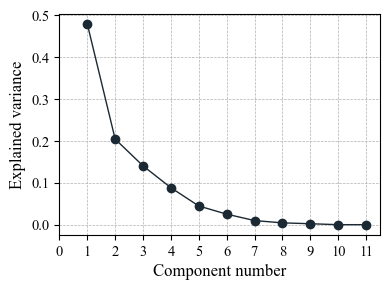

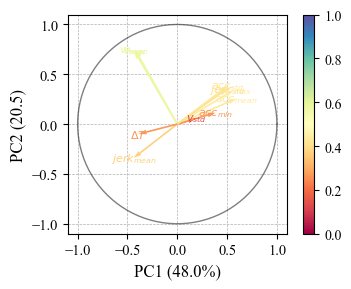

In [6]:
# 创建加速事件PCA降维类
acc_dr = DimensionReduce(ss_acc_index)
acc_tve = acc_dr.calc_total_variance_explain()
acc_tve.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/加速事件_主成分总解释方差.xlsx', index=False)

acc_pc_load = acc_dr.calc_PC_loadings()
acc_pc_load.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/加速事件_主成分载荷.xlsx', index=True)

acc_rc_load = acc_dr.calc_RC_loadings()
acc_rc_load.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/加速事件_主成分旋转载荷.xlsx', index=True)

show_scree_plot(acc_tve)
plt.savefig('/Users/zhangjianhua/Desktop/明觉数据分析/GpsFigure/主成分分析结果/加速事件_主成分碎石图.pdf')

acc_labels = [r'$v_{max}$', r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$',
              r'$acc_{max}$', r'$acc_{mean}$', r'$acc_{std}$',  r'$acc_{min}$',
              r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$']
show_correlation_plot(acc_pc_load, x_cols=[
                      'PC1', 'PC2'], text_labels=acc_labels, xy_labels=['PC1 (48.0%)', 'PC2 (20.5)'])
plt.savefig('/Users/zhangjianhua/Desktop/明觉数据分析/GpsFigure/主成分分析结果/加速事件_原始特征与主成分相关关系图.pdf')


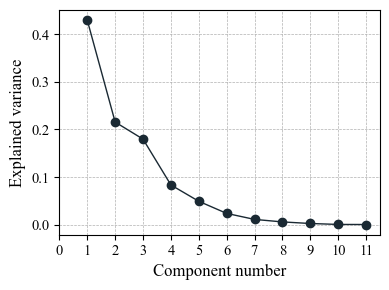

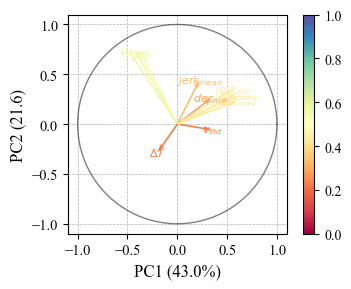

In [7]:
# 创建减速事件PCA降维类
dec_dr = DimensionReduce(ss_dec_index)
dec_tve = dec_dr.calc_total_variance_explain()
dec_tve.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/刹车事件_主成分总解释方差.xlsx', index=False)

dec_pc_load = dec_dr.calc_PC_loadings()
dec_pc_load.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/刹车事件_主成分载荷.xlsx', index=True)

dec_rc_load = dec_dr.calc_RC_loadings()
dec_rc_load.to_excel('/Users/zhangjianhua/Desktop/明觉数据分析/GpsData/主成分分析结果/刹车事件_主成分旋转载荷.xlsx', index=True)

show_scree_plot(dec_tve)
plt.savefig('/Users/zhangjianhua/Desktop/明觉数据分析/GpsFigure/主成分分析结果/刹车事件_主成分碎石图.pdf')

dec_labels = [r'$v_{max}$',r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$',
          r'$dec_{max}$', r'$dec_{mean}$', r'$dec_{std}$',  r'$dec_{min}$',
          r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$']
show_correlation_plot(dec_pc_load, x_cols=['PC1','PC2'], text_labels=dec_labels, xy_labels=['PC1 (43.0%)', 'PC2 (21.6)'])
plt.savefig('/Users/zhangjianhua/Desktop/明觉数据分析/GpsFigure/主成分分析结果/刹车事件_原始特征与主成分相关关系图.pdf')

### 5. 一层速度聚类
#### 对加速和刹车事件速度特征['max_v','mean_v', 'std_v', 'min_v']进行标准化后一阶段聚类分析
#### 通过降维对降维后的数据可视化

In [8]:
data = pd.concat([acc_data,dec_data],axis=0).reset_index(drop=True)

#### 5.1 速度特征标准化

In [9]:
# 读取标准化后的一级聚类特征数据
speed_index = data[['max_v','mean_v', 'std_v', 'min_v']]
speed_ss = Standard(speed_index)
ss_speed_index = speed_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(speed_ss,'../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标_数据标准化模型.pkl') 

['../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标_数据标准化模型.pkl']

In [16]:
ss_speed_index.columns = ['ss_'+i for i in ss_speed_index.columns.to_list()]
ss_speed_index

,ss_max_v,ss_mean_v,ss_std_v,ss_min_v
0,-1.400024,-1.341252,-0.535997,-1.225768
1,-1.524286,-1.455157,-0.549466,-1.268858
2,-1.264465,-1.119074,-0.947820,-0.870277
3,-0.897327,-0.749346,-0.867648,-0.584808
4,-0.671397,-0.535384,-0.861533,-0.310110
...,...,...,...,...
430275,0.955306,0.313650,3.371295,-0.283179
430276,-0.609266,-0.881868,1.942830,-1.188065
430277,0.079824,0.149164,-0.560810,0.239285
430278,0.480851,0.276794,3.579387,-0.913367


#### 5.2 基于标准化后的的特征进行聚类，返回聚类结果

In [17]:
data = pd.concat([data, ss_speed_index], axis=1)
# 创建加速、减速事件的聚类类
speed_clus = Clustering(data[ss_speed_index.columns.to_list(
)], calc_best_cluster_flag=False, max_cluster=10, best_cluster=2)
print('完成聚类')
if speed_clus.calc_best_cluster_flag:
    speed_clus.show_silhouette_clusters()
    print('轮廓系数：{}'.format(speed_clus.silhouette_scores))
    plt.savefig('../GpsFigure/两阶段聚类/一阶段速度聚类/速度相关指标_聚类数与轮廓系数图.pdf')
data['v_label'] = speed_clus.best_labels
data.to_excel('../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标_聚类结果.xlsx', index=False)

# 速度聚类模型保存
joblib.dump(speed_clus, '../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标__聚类模型.pkl')


完成聚类


['../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标__聚类模型.pkl']

#### 5.3 标准化速度特征进行降维,追加至加速事件原始数据中

In [18]:
# 创建加速事件PCA降维类
speed_dr = DimensionReduce(ss_speed_index, n_pc=2)
speed_tve = speed_dr.calc_total_variance_explain()
speed_tve.to_excel(
    '../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_主成分总解释方差.xlsx', index=False)

speed_rc_load = speed_dr.calc_RC_loadings()
speed_rc_load.to_excel(
    '../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_主成分旋转载荷.xlsx', index=True)

data = pd.concat([data, speed_dr.pcs], axis=1)
data = data.rename(columns={'PC1': 'v_PC1', 'PC2': 'v_PC2'})
data.to_excel('../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx', index=False)

# 速度PCA降维模型保存
joblib.dump(speed_dr, '../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl')


['../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl']

#### 5.4 可视化聚类轮廓系数结果

The average silhouette score of all samples:  0.4826878658910443
The average silhouette score of cluster 0 : 0.46
The average silhouette score of cluster 1 : 0.51


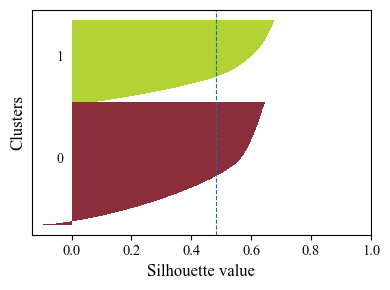

In [20]:
data = pd.read_excel('../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx')
cls_list = list(data[['max_v', 'mean_v', 'std_v', 'min_v', 'v_label']].groupby(
    'v_label').mean().sort_values(by='max_v').index)
show_silhouette_plot(data.sample(n=100000, random_state=42), x_cols=['v_PC1', 'v_PC2'], y_col='v_label',
                     num_cls=2, cls_list=cls_list, colors=['#8a2e3b', '#b2d235', '#dea32c', '#6950a1'])
plt.savefig('../GpsFigure/两阶段聚类/一阶段速度聚类/标准化速度相关指标_最优聚类轮廓图.png', dpi=1200)


#### 5.5 可视化聚类散点图

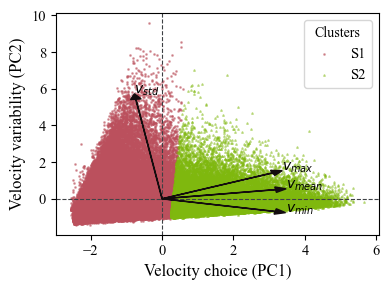

In [21]:
speed_dr = joblib.load('../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl')
cls_list = list(data[['max_v', 'mean_v', 'std_v', 'min_v', 'v_label']].groupby(
    'v_label').mean().sort_values(by='max_v').index)

show_class_result(data.sample(100000, random_state=42), PC_list=['v_PC1', 'v_PC2'], label='v_label',
                  pca=speed_dr.pca, num_cls=2, feature_num=4,
                  arrow_text_list=[
                      r'$v_{max}$', r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$'],
                  xy_labels=[
                      'Velocity choice (PC1)', 'Velocity variability (PC2)'],
                  cls_list=cls_list, cls_legend=['S1', 'S2'], cls_colors=['#bb505d', '#7fb80e', '#4e72b8'],
                  vector_scale=1.5)

plt.savefig('../GpsFigure/两阶段聚类/一阶段速度聚类/标准化速度相关指标_聚类散点图.png', dpi=1200)


#### 5.5 求解速度聚类中心点

In [23]:
centers = speed_clus.best_kmeans.cluster_centers_
x_centers = speed_ss.scaler.inverse_transform(centers)
x_centers = pd.DataFrame(x_centers, columns=speed_index.columns)
x_centers.to_excel('../GpsData/两阶段聚类/一阶段速度聚类/速度相关指标_聚类中心点.xlsx', index=False)

### 6. 加速事件中不同速度分类下进行二阶聚类，获取激进加速度事件

#### 6.1 对加速事件中的加速度特征进行标准化，并返回标准化后的结果scaler_acc_X

In [30]:
data = pd.read_excel('../GpsData/两阶段聚类/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx')
# 提取加速事件的加速度特征指标进行标准化
acc_data = data[data['logo'] == '加速事件'].reset_index(drop=True)
acc_X = acc_data[['max_acc_lon', 'mean_acc_lon', 'std_acc_lon',
                  'min_acc_lon', 'mean_jerk', 'std_jerk', 'duration']]
acc_ss = Standard(acc_X)
scaler_acc_X = acc_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(acc_ss, '../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_数据标准化模型.pkl')


['../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_数据标准化模型.pkl']

In [31]:
scaler_acc_X.columns = ['ss_'+i for i in scaler_acc_X.columns.to_list()]
acc_data = pd.concat([acc_data, scaler_acc_X], axis=1)

In [32]:
# 提取减速事件的减速度特征指标进行标准化
dec_data = data[data['logo'] == '刹车事件'].reset_index(drop=True)
dec_X = dec_data[['max_dec_lon', 'mean_dec_lon', 'std_dec_lon',
                  'min_dec_lon', 'mean_jerk', 'std_jerk', 'duration']]
dec_ss = Standard(dec_X)
scaler_dec_X = dec_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(dec_ss, '../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_数据标准化模型.pkl')


['../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_数据标准化模型.pkl']

In [33]:
scaler_dec_X.columns = ['ss_'+i for i in scaler_dec_X.columns.to_list()]
dec_data = pd.concat([dec_data, scaler_dec_X], axis=1)

#### 6.2 对加速、减速特征进行进行降维，追加到原始速度中

In [34]:
# 创建加速事件PCA降维类
acc_dr = DimensionReduce(scaler_acc_X,n_pc=2)
acc_tve = acc_dr.calc_total_variance_explain()
acc_tve.to_excel('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_主成分总解释方差.xlsx', index=False)

acc_rc_load = acc_dr.calc_RC_loadings()
acc_rc_load.to_excel('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_主成分旋转载荷.xlsx', index=True)

acc_data = pd.concat([acc_data,acc_dr.pcs],axis=1)
acc_data = acc_data.rename(columns={'PC1': 'acc_PC1', 'PC2': 'acc_PC2'})
acc_data.to_excel('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(acc_dr,'../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_降维模型.pkl')

['../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_降维模型.pkl']

In [45]:
# 创建减速事件PCA降维类
dec_dr = DimensionReduce(scaler_dec_X,n_pc=2)
dec_tve = dec_dr.calc_total_variance_explain()
dec_tve.to_excel('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_主成分总解释方差.xlsx', index=False)

dec_rc_load = dec_dr.calc_RC_loadings()
dec_rc_load.to_excel('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_主成分旋转载荷.xlsx', index=True)

dec_data = pd.concat([dec_data,dec_dr.pcs],axis=1)
dec_data = dec_data.rename(columns={'PC1': 'dec_PC1', 'PC2': 'dec_PC2'})
dec_data.to_excel('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(dec_dr,'../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_降维模型.pkl')


['../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_降维模型.pkl']

#### 6.3 基于标准化的加速度特征进行二级聚类，返回聚类轮廓图和聚类中心点

完成0聚类
The average silhouette score of all samples:  0.3908497621264898
The average silhouette score of cluster 0 : 0.52
The average silhouette score of cluster 1 : 0.29
The average silhouette score of cluster 2 : 0.13
完成1聚类
The average silhouette score of all samples:  0.4038964734419565
The average silhouette score of cluster 0 : 0.56
The average silhouette score of cluster 1 : 0.29
The average silhouette score of cluster 2 : 0.22


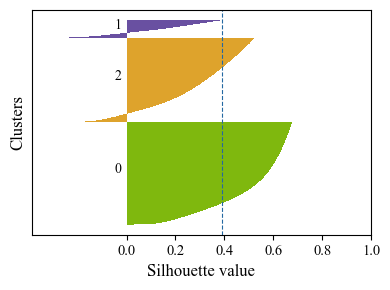

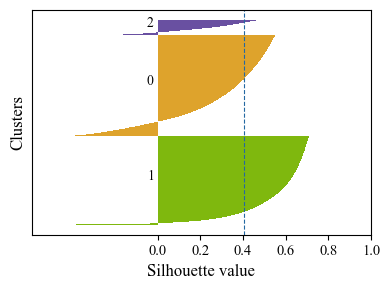

In [38]:
acc_data = pd.read_excel('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_主成分结果.xlsx')
all_acc_event = []
for i in range(2):
    acc_event = acc_data[acc_data['v_label'] == i]
    acc_clus = Clustering(
        acc_event[scaler_acc_X.columns.to_list()], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if acc_clus.calc_best_cluster_flag:
        acc_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, acc_clus.silhouette_scores))
        plt.savefig(
            '../GpsFigure/两阶段聚类/二阶段加速聚类/speed{}_加速相关指标_聚类数与轮廓系数图.pdf'.format(i))
    acc_event['acc_label'] = acc_clus.best_labels
    all_acc_event.append(acc_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(acc_event[['max_acc_lon', 'acc_label']].groupby(
        'acc_label').mean().sort_values(by='max_acc_lon').index)
    show_silhouette_plot(acc_event, x_cols=['acc_PC1', 'acc_PC2'], y_col='acc_label',
                         num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig(
        '../GpsFigure/两阶段聚类/二阶段加速聚类/speed{}_加速相关指标_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = acc_clus.best_kmeans.cluster_centers_
    # x_centers = acc_dr.pca.inverse_transform(centers)
    x_centers = acc_ss.scaler.inverse_transform(centers)
    x_centers = pd.DataFrame(x_centers, columns=acc_X.columns)
    x_centers.to_excel(
        '../GpsData/两阶段聚类/二阶段加速聚类/speed{}_加速相关指标_聚类中心点.xlsx'.format(i), index=False)

all_acc_event = pd.concat(all_acc_event, axis=0).reset_index(drop=True)
all_acc_event.to_excel(
    '../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_聚类结果.xlsx', index=False)


#### 6.4 可视化加速度特征二阶段聚类散点图

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font',family='Times New Roman')

def show_class_result(data:pd.DataFrame, PC_list:list, label:str, pca, num_cls:int, feature_num:int, arrow_text_list:list, xy_labels:list, 
                      cls_list:list, cls_legend:list, cls_colors = ['#bb505d','#7fb80e','#4e72b8'], vector_scale:float = 1):
    """绘制降维后的散点图
    Args:
        data (pd.DataFrame): 需要绘制散点的数据集
        PC_list (list): 散点图x,y轴对应数据data中的列名
        label (str): 散点图分类标签对应数据data中的列名
        pca (_type_): 降维散点图中所使用的pca模型
        num_cls (_int_): 散点分类的个数
        feature_num (int): 降维前的数据原始特征数
        arrow_text_list (list): 原始特征的标签
        xy_labels (list): 绘图坐标轴的标题
        cls_list (list): 分类标签的列表
        cls_legend (list): 绘图中所使用的分类图例
        cls_colors (list, optional): 散点分类所使用的颜色. Defaults to ['#bb505d','#7fb80e','#4e72b8'].
        vector_scale (float, optional): 矢量图缩放比例. Defaults to 1.
    """    
    fig,ax = plt.subplots(figsize=(4,3))

    # 绘制原点的水平线和垂直线
    ax.axhline(y=0, color='#3e4145', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='#3e4145', linestyle='--', linewidth=0.8)
    
    # 可视化分类结果
    # 按照label列分组，将不同的标签对应的数据分别绘制在散点图上，并使用不同颜色表示
    marker_list = ['o', '^', 'x', 'D']
    for i in range(num_cls):
        x = data.loc[data[label] == cls_list[i], PC_list[0]]
        y = data.loc[data[label] == cls_list[i], PC_list[1]]
        plt.scatter(x, y, c=cls_colors[i], label=cls_legend[i], marker=marker_list[i], s=1, alpha=0.5)
    
    # 绘制原始特征的向量线
    features = np.eye(feature_num)
    feature_vectors = pca.transform(features)
    for i, (x, y) in enumerate(feature_vectors[:,[0,1]]):
        plt.arrow(0, 0, x*feature_num*vector_scale, y*feature_num*vector_scale, color='#130c0e',width=0.01, head_width=0.3, 
                head_length=0.3, length_includes_head=True, zorder=100)
        plt.text(x*feature_num*vector_scale, y*feature_num*vector_scale, arrow_text_list[i], fontsize=10, color='k')
    
    # 设置轴标题
    plt.xlabel(xy_labels[0], fontsize=12)
    plt.ylabel(xy_labels[1], fontsize=12)
    

    plt.xlim([-7.5,20])
    plt.ylim([-7.5,10])
    
    # 设置轴刻度属性
    plt.xticks(fontsize=10.5)
    plt.yticks(fontsize=10.5)
    
    # 设置图例
    plt.legend(title='Clusters', fontsize=10.5, loc='upper right')
    plt.tight_layout()
    

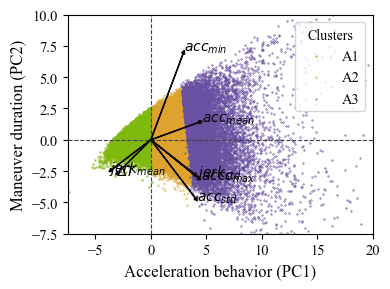

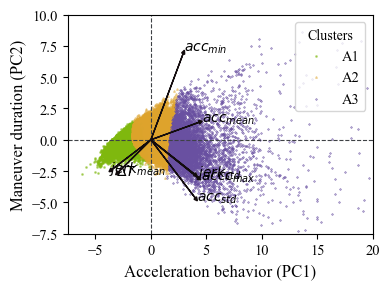

In [42]:
acc_data = pd.read_excel('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_聚类结果.xlsx')
# 速度聚类模型保存
acc_dr = joblib.load('../GpsData/两阶段聚类/二阶段加速聚类/加速相关指标_降维模型.pkl')
for i in range(2):
    event = acc_data[acc_data['v_label'] == i]
    cls_list = list(event[['max_acc_lon', 'acc_label']].groupby('acc_label').mean().sort_values(
        by='max_acc_lon').index)
    show_class_result(event, PC_list=['acc_PC1', 'acc_PC2'], label='acc_label',  pca=acc_dr.pca,
                      num_cls=3, feature_num=7,
                      arrow_text_list=[r'$accc_{max}$', r'$acc_{mean}$', r'$acc_{std}$',
                                       r'$acc_{min}$', r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$'],
                      xy_labels=[
                          'Acceleration behavior (PC1)', 'Maneuver duration (PC2)'],
                      cls_list=cls_list, cls_legend=['A1', 'A2', 'A3'],
                      cls_colors=['#7fb80e', '#dea32c', '#6950a1'],
                      vector_scale=1.5)
    plt.savefig(
        '../GpsFigure/两阶段聚类/二阶段加速聚类/速度{}_加速相关指标_聚类散点图.png'.format(i), dpi=1200)


In [43]:
acc_data[acc_data['v_label']==0].groupby('acc_label').count()

,phone,start_time,end_time,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,...,v_PC2,ss_max_acc_lon,ss_mean_acc_lon,ss_std_acc_lon,ss_min_acc_lon,ss_mean_jerk,ss_std_jerk,ss_duration,acc_PC1,acc_PC2
acc_label,,,,,,,,,,,,,,,,,,,,,
0,75507,75507,75507,75507,75507,75507,75507,75507,75507,75507,...,75507,75507,75507,75507,75507,75507,75507,75507,75507,75507
1,12747,12747,12747,12747,12747,12747,12747,12747,12747,12747,...,12747,12747,12747,12747,12747,12747,12747,12747,12747,12747
2,61720,61720,61720,61720,61720,61720,61720,61720,61720,61720,...,61720,61720,61720,61720,61720,61720,61720,61720,61720,61720


In [44]:
acc_data[acc_data['v_label']==0].groupby('acc_label').mean()

,phone,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,std_acc_lon,min_acc_lon,...,v_PC2,ss_max_acc_lon,ss_mean_acc_lon,ss_std_acc_lon,ss_min_acc_lon,ss_mean_jerk,ss_std_jerk,ss_duration,acc_PC1,acc_PC2
acc_label,,,,,,,,,,,,,,,,,,,,,
0,1.435397e+10,10.529103,28.302450,38.590417,33.502404,3.574880,0.552288,0.301653,0.154579,0.087015,...,-0.353733,-0.440160,-0.439655,-0.407591,-0.308586,0.357738,-0.453829,0.273422,-1.026287,0.017474
1,1.442005e+10,4.186946,22.256476,32.570048,27.307429,4.578741,1.475787,0.864279,0.493345,0.407601,...,-0.032428,2.160042,2.440774,1.909515,2.044005,-2.091390,2.043632,-0.979996,5.215998,0.393534
2,1.441021e+10,6.450778,24.561525,35.240987,29.796995,4.072964,0.940294,0.521892,0.289440,0.178060,...,-0.197744,0.652307,0.687881,0.514835,0.359539,-0.262054,0.537572,-0.532589,1.361415,-0.039613


#### 6.5 基于标准化的减速度特征进行二级聚类，返回聚类轮廓图和聚类中心点

In [53]:
scaler_dec_X.columns.to_list()

['ss_max_dec_lon',
 'ss_mean_dec_lon',
 'ss_std_dec_lon',
 'ss_min_dec_lon',
 'ss_mean_jerk',
 'ss_std_jerk',
 'ss_duration']

完成0聚类
The average silhouette score of all samples:  0.4154336754023674
The average silhouette score of cluster 0 : 0.48
The average silhouette score of cluster 1 : 0.20
The average silhouette score of cluster 2 : 0.33
完成1聚类
The average silhouette score of all samples:  0.36714846349521224
The average silhouette score of cluster 0 : 0.50
The average silhouette score of cluster 1 : 0.30
The average silhouette score of cluster 2 : 0.17


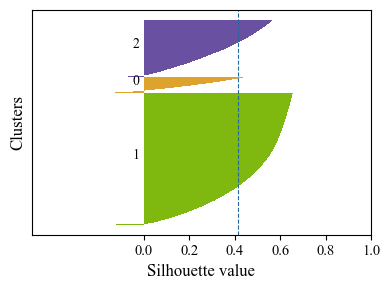

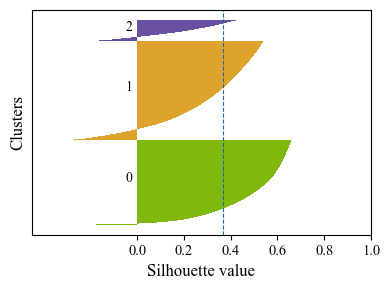

In [50]:
dec_data = pd.read_excel('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_主成分结果.xlsx')
all_dec_event = []
for i in range(2):
    dec_event = dec_data[dec_data['v_label'] == i]
    dec_clus = Clustering(dec_event[scaler_dec_X.columns.to_list(
    )], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if dec_clus.calc_best_cluster_flag:
        dec_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, dec_clus.silhouette_scores))
        plt.savefig(
            '../GpsFigure/两阶段聚类/二阶段刹车聚类/speed{}_减速相关指标_聚类数与轮廓系数图.pdf'.format(i))
    dec_event['dec_label'] = dec_clus.best_labels
    all_dec_event.append(dec_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(dec_event[['max_dec_lon', 'dec_label']].groupby(
        'dec_label').mean().sort_values(by='max_dec_lon').index)
    show_silhouette_plot(dec_event, x_cols=['dec_PC1', 'dec_PC2'], y_col='dec_label',
                         num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig(
        '../GpsFigure/两阶段聚类/二阶段刹车聚类/speed{}_减速相关指标_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = dec_clus.best_kmeans.cluster_centers_
    x_centers = dec_ss.scaler.inverse_transform(centers)
    x_centers = pd.DataFrame(x_centers, columns=dec_X.columns)
    x_centers.to_excel(
        '../GpsData/两阶段聚类/二阶段刹车聚类/speed{}_减速相关指标_聚类中心点.xlsx'.format(i), index=False)
all_dec_event = pd.concat(all_dec_event, axis=0).reset_index(drop=True)
all_dec_event.to_excel(
    '../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_聚类结果.xlsx', index=False)


#### 6.6 可视化二阶段减速度聚类结果散点图

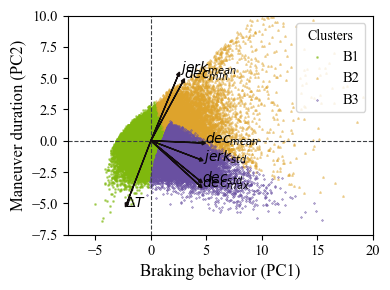

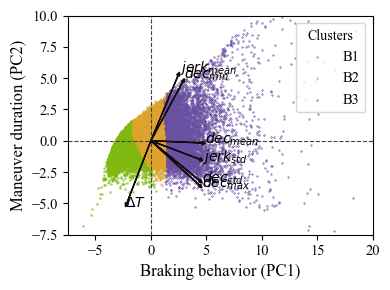

In [52]:
dec_data = pd.read_excel('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标__聚类结果.xlsx')
# 速度聚类模型保存
dec_dr = joblib.load('../GpsData/两阶段聚类/二阶段刹车聚类/减速相关指标_降维模型.pkl')
for i in range(2):
    event = dec_data[dec_data['v_label']==i]
    cls_list = list(event[['max_dec_lon','dec_label']].groupby('dec_label').mean().sort_values(by='max_dec_lon').index)
    show_class_result(event, PC_list=['dec_PC1','dec_PC2'], label='dec_label',  pca=dec_dr.pca, 
                  num_cls=3, feature_num=7, 
                  arrow_text_list=[r'$dec_{max}$', r'$dec_{mean}$', r'$dec_{std}$',  r'$dec_{min}$', r'$jerk_{mean}$', r'$jerk_{std}$', r'$\Delta T$'],
                  xy_labels = ['Braking behavior (PC1)', 'Maneuver duration (PC2)'], 
                  cls_list=cls_list, cls_legend=['B1','B2', 'B3'], 
                  cls_colors = ['#7fb80e', '#dea32c', '#6950a1'], 
                  vector_scale = 1.5)
    plt.savefig('../GpsFigure/两阶段聚类/二阶段刹车聚类/速度{}_减速相关指_聚类散点图.png'.format(i), dpi=1200)

In [12]:
dec_data[dec_data['v_label']==0].groupby('dec_label').mean()

,phone,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,std_acc_lon,min_acc_lon,...,min_jerk,max_dec_lon,mean_dec_lon,std_dec_lon,min_dec_lon,v_PC1,v_PC2,v_label,dec_PC1,dec_PC2
dec_label,,,,,,,,,,,,,,,,,,,,,
0,1.439845e+10,12.082399,60.906778,69.865020,65.505034,3.070049,NaN,NaN,NaN,NaN,...,-0.285404,0.486296,0.232323,0.137292,0.057983,2.034291,-0.160273,0.0,-1.918356,0.085155
1,1.441737e+10,6.852318,57.254051,66.883140,62.450535,3.639160,NaN,NaN,NaN,NaN,...,-0.520326,0.934311,0.446729,0.301739,0.127518,1.695846,0.031977,0.0,0.067009,0.415075
2,1.439801e+10,5.033416,55.302962,67.248242,62.110736,5.045986,NaN,NaN,NaN,NaN,...,-0.861492,1.720682,0.841346,0.632829,0.271892,1.559944,0.607783,0.0,3.574301,0.444591


In [11]:
len(dec_data[dec_data['v_label']==0])

82667

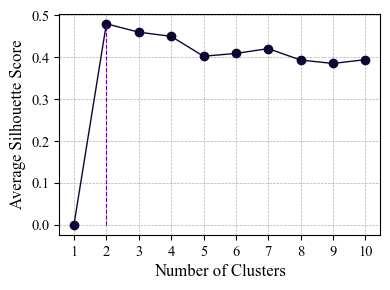

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rc('font',family='Times New Roman')

data = pd.read_excel('./事件聚类/all事件_speed指标_聚类数与轮廓系数对应表.xlsx')
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(data['cluster'], data['silhouette'],'-o', color='#120432',linewidth=1)
plt.plot([2,2],[0,data['silhouette'].iloc[1]],'--',color='#5E0583', linewidth=0.8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(data['cluster'],fontsize=10.5)
plt.yticks(fontsize=10.5)
plt.grid(linestyle='--',linewidth=0.5)
plt.tight_layout()
plt.savefig('./事件聚类/all事件_speed指标_聚类数与轮廓系数对应关系.pdf')